In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits
from tqdm import tqdm
import itertools

# Modified bessel function of the first kind
from scipy.special import iv
from scipy.optimize import curve_fit
import powerlaw
import lmfit

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall, discretizeTrajectory, discretizeTrajectoryIndices

sys.path.append('../../ant_simulation/')
from ant_sim import autocorrelation

# Update source files before running each cell
%load_ext autoreload
%autoreload 2

# First color is for uncropped, second for cropped
colors = ['tab:blue', 'tab:green']

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


In [2]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2026-01-01.h5'
#dataFile = '/home/jack/Workspaces/data/ant_simulation/bounded_test_dataset_true.h5'

# We will want to look at longer trajectories here since we want to examine
# timescales longer than 5 seconds.
minimumLength = 5 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = True
excludeObjects = True

padding = 15 # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Removing trajectories near walls: 100%|███████| 496/496 [01:28<00:00,  5.62it/s]

Loaded 842 segments!


In [357]:
def computeAngles(trajectory, dt=1, minVelocityThreshold=0):
    # Compute the velocity for the trajectory
    velocityArr = (trajectory[1:] - trajectory[:-1]) / dt
    velocityMagnitudes = np.sqrt(np.sum(velocityArr**2, axis=-1))

    velocityArr = velocityArr[velocityMagnitudes > minVelocityThreshold]
    velocityMagnitudes = velocityMagnitudes[velocityMagnitudes > minVelocityThreshold]

    # Make unit vectors
    velocityArr[:,0] = velocityArr[:,0] / velocityMagnitudes
    velocityArr[:,1] = velocityArr[:,1] / velocityMagnitudes

    # Now take angle differences for the steps
    # The clip is to avoid numerical errors
    angleDifferenceArr = np.array([np.arccos(np.clip(np.dot(velocityArr[i], velocityArr[i+1]), -1., 1.)) for i in range(len(velocityArr)-1)])

    # To compute the sign of the angle, we need
    # to use the cross product
    signArr = np.array([np.sign(np.cross(velocityArr[i], velocityArr[i+1])) for i in range(len(velocityArr)-1)])
    angleDifferenceArr = angleDifferenceArr * signArr
    
    return angleDifferenceArr[~np.isnan(angleDifferenceArr)]

# Exponential function that we use for fitting tau, Dr,
# and persistence time. Already normalized assuming xmin = 0
def exponential(x, x0, A):
    return np.exp(-x / x0) * A

def computeRotationalDiffusion(trajectory, c, v, minStepsPerRun, minDistancePerRun, t=None):
    """
    Compute the rotational diffusion coefficient, assuming
    that the trajectory data follows a run-and-tumble scheme.

    This is done by discretizing the trajectory as a run-and-tumble,
    removing all of the angle changes ascribed to tumbles, and then
    computing the persistence time.
    
    Parameters
    ----------
    trajectory : numpy.ndarray[N,2] or list of numpy.ndarray[N,2]
        The trajectory to compute the rotational diffusion coefficient
        for.

        Can also be a list of disjoint segments representing the same
        trajectory (for example, if there are gaps in a trajectory that
        should be avoided in calculate the persistence, but you want
        to average over the entire collection of segments).

    theta : float
        The angle threshold parameter used for discretizing the
        trajectory, in radians.

    v : float
        The velocity threshold parameter used for discretizing the
        trajectory.

    minStepsPerRun : int
        The minimum number of steps per run for discretizing the
        trajectory.
        
    minDistancePerRun : float
        The minimum distance per run for discretizing the
        trajectory. Given in whatever units ``trajectory`` is given in.

    t : float or numpy.ndarray[N,2] or list of numpy.ndarray[N,2], optional
        The time points at which the data is sampled. If all samples are
        evenly spaced, can be a single float representing the time difference.

        If ``trajectory`` is given as a list of segments, this should be structured
        similarly.

        If not given, all samples will be assumed to be spaced evenly, and ``v`` will
        be given in units of distance/frames (where the distance unit is whatever
        the units of ``trajectory`` are.
    """
    if type(trajectory) is list:
        segmentList = trajectory
        
    else:
        segmentList = [trajectory]

    if not hasattr(t, '__iter__'):
        # If t is None, we just use a spacing of 1
        if not t:
            dt = 1

        # Otherwise we expect that t is the dt value
        else:
            dt = t

        # Now we just generate an array of times the same shape as trajectory
        timeList = [np.arange(len(segmentList[i]))*dt for i in range(len(segmentList))]
        
    else:
        # If we are given a proper t array, we should be able to copy it directly
        if type(t) is list and type(trajectory) is list:
            # Make sure it has the same shape
            for i in range(len(trajectory)):
                assert len(t[i]) == len(trajectory[i])

            timeList = t

        else:
            # Otherwise, we only have a single segment, so just make sure they are
            # the same length, and then save.
            assert len(t) == len(segmentList[0])
            timeList = [t]

    # For ease of calculation, we just append every segment together. You
    # could also calculate the Dr value for each segment individually, but at
    # that point, you may as well just pass the segments in separate calls
    # to this function, so we don't loose any functionality like this.
    straightenedData = np.zeros((0, 2))

    # Technically this could change between segments, but it really shouldn't
    dt = np.min(timeList[0][1:] - timeList[0][:-1])

    # Now we actually start working with the trajectories
    for i in range(len(segmentList)):
        
        # First, we need to discretize the segment
        data = segmentList[i]
        time = timeList[i]
        
        runIntervals, waitIntervals = discretizeTrajectoryIndices(data,
                                                                  c=c,
                                                                  velocityThreshold=v,
                                                                  dt=dt,
                                                                  minSteps=minStepsPerRun,
                                                                  minDistancePerRun=minDistancePerRun,
                                                                  debug=False)

        # If we have detected no runs, we continue on to the next segment
        if len(runIntervals) == 0:
            continue

        # Compute the turning points based on the run intervals
        # First point is just the first point in the first run interval (no
        # averaging)
        discretePoints = [data[runIntervals[0][0]]]
        # Now we take the average of the end of the previous run and the start
        # of the new one.
        for i in range(1, len(runIntervals)):
            discretePoints += [np.mean([data[runIntervals[i][0]],
                                        data[runIntervals[i-1][1]]], axis=0)]
    
        # And we add the last point of the last run
        discretePoints += [data[runIntervals[-1][1]]]
    
        # If we had L run intervals, we should now have L+1 discrete points
        discretePoints = np.array(discretePoints)

        # Now we'll figure out the angles between subsequent runs
        dirVectors = discretePoints[1:] - discretePoints[:-1]
        # Normalize
        dirVectors = (dirVectors.T / np.sqrt(np.sum(dirVectors**2, axis=-1))).T

        # The clip is to avoid numerical errors
        angleDifferenceArr = np.array([np.arccos(np.clip(np.dot(dirVectors[i], dirVectors[i+1]), -1., 1.)) for i in range(len(dirVectors)-1)])
    
        # To compute the sign of the angle, we need
        # to use the cross product
        signArr = np.array([np.sign(np.cross(dirVectors[i], dirVectors[i+1])) for i in range(len(dirVectors)-1)])
        angleDifferenceArr = angleDifferenceArr * signArr

        def rotationMatrix(angle):
            """
            Generate a rotation matrix in 2D.

            Parameters
            ----------
            angle : float
                The angle in radians to rotate.
            """
            return np.array([[np.cos(angle), -np.sin(angle)],
                             [np.sin(angle), np.cos(angle)]])

        adjustedPoints = np.copy(data)

        # Now we need to make note of which points are actually part of a run,
        # since we want to chop out the waiting/tumbling times. But we have to
        # actually do the chopping after rotating, otherwise it will mess
        # up our indexing.
        isInRun = np.zeros(len(adjustedPoints), dtype=bool)
        # These indices index adjustedPoints *after* we have removed
        # the waiting times, and helps to remove gaps that would have
        # been filled by those tumbling times.
        skipIndices = []
        
        for i in range(len(runIntervals)):
            isInRun[runIntervals[i][0]:runIntervals[i][1]] = True

            # We don't need the last one
            if i < len(runIntervals) - 1:
                skipIndices.append(np.sum(isInRun[:runIntervals[i][1]]))
            
        # Next, we rotate each run so we remove the effects on persistence from the
        # tumbles, leaving only the meandering rotational diffusion.
        # We start at the end for this, and then each rotation is applied to
        # EVERYTHING afterwards.
        for i in range(len(angleDifferenceArr))[::-1]:
            rMat = rotationMatrix(angleDifferenceArr[i])
            startIndex = runIntervals[i+1][0]
            
            rotatedPoints = adjustedPoints[startIndex:]
            rotatedPoints = (rotatedPoints - rotatedPoints[0]) @ rMat + rotatedPoints[0]
            adjustedPoints[startIndex:] = rotatedPoints


        # Now cut out the waiting times
        adjustedPoints = adjustedPoints[isInRun]
        
        # Now remove the skips
        for i in skipIndices[::-1]:
            adjustedPoints[i:] += -adjustedPoints[i] + adjustedPoints[i-1]

        # DEBUG
        plt.plot(*data.T)
        plt.plot(*adjustedPoints.T, '-o')
        
        # Move the first point to the last point from the last segment and
        # rotate to match the previous orientation (if available)
        if len(straightenedData) > 0:
            # Compute average direction
            dirVectors = adjustedPoints[1:] - adjustedPoints[:-1]
            dirVectors = (dirVectors.T / np.sqrt(np.sum(dirVectors**2, axis=-1))).T

            # Has to be nanmedian since the gap removal process will leave some 
            # identical points, which will give a dir vector of nan, nan.
            meanDirVector = np.nanmedian(dirVectors, axis=0)
            
            previousDirVectors = straightenedData[1:] - straightenedData[:-1]
            previousDirVectors = (previousDirVectors.T / np.sqrt(np.sum(previousDirVectors**2, axis=-1))).T
            
            meanPreviousDirVector = np.nanmedian(previousDirVectors, axis=0)
            
            # The clip is to avoid numerical errors
            angleDifference = np.arccos(np.clip(np.dot(meanDirVector, meanPreviousDirVector), -1, 1))
        
            # To compute the sign of the angle, we need
            # to use the cross product
            sign = np.sign(np.cross(meanPreviousDirVector, meanDirVector))
            angleDifference = angleDifference * sign
            
            adjustedPoints = (adjustedPoints - adjustedPoints[0]) @ rotationMatrix(angleDifference) + straightenedData[-1]

            # DEBUG
            plt.plot(*np.array([meanDirVector, meanDirVector*10]).T)
            plt.plot(*np.array([meanPreviousDirVector, meanPreviousDirVector*10]).T)
            
        straightenedData = np.concatenate((straightenedData, adjustedPoints))

        # DEBUG
        plt.plot(*discretePoints.T, '-o')
        plt.gca().set_aspect(1)
        plt.show()
        
    # DEBUG
    plt.plot(*straightenedData.T, '-o')
    plt.gca().set_aspect(1)
    plt.show()

    # Compute the autocorrelation
    angles = computeAngles(straightenedData,
                           dt=dt,
                           minVelocityThreshold=v)

    cumAngles = np.cumsum(angles)
    cosArr = np.cos(cumAngles)

    # Shorter max lag than for the full persistence time, since we're
    # generally gonna be working with shorter segments
    tArr, autocorrArr = autocorrelation(cosArr, maxLag=1, dt=dt, dtau=dt)

    # Fit with an exponential
    try:
        pOpt, pCov, info, mesg, success = curve_fit(exponential, tArr, autocorrArr, full_output=True, p0=(1, 1))
        # 1/param since diffusion coefficient has units of inverse seconds
        Dr = 1/pOpt[0]
        pErr = np.sqrt(np.diag(pCov))
        Dr_err = 1/pErr[0]
        
        # print(Dr, Dr_err)
        
        # DEBUG
        plt.plot(tArr, autocorrArr)
        plt.plot(tArr, exponential(tArr, *pOpt))
        plt.yscale('log')
        plt.show()

        if Dr <= 0:
            return np.nan, np.nan
            
        return Dr, Dr_err
        
    except:
        return np.nan, np.nan

In [437]:
def computeAngles(trajectory, dt=1, minVelocityThreshold=0):
    # Compute the velocity for the trajectory
    velocityArr = (trajectory[1:] - trajectory[:-1]) / dt
    velocityMagnitudes = np.sqrt(np.sum(velocityArr**2, axis=-1))

    velocityArr = velocityArr[velocityMagnitudes > minVelocityThreshold]
    velocityMagnitudes = velocityMagnitudes[velocityMagnitudes > minVelocityThreshold]

    # Make unit vectors
    velocityArr[:,0] = velocityArr[:,0] / velocityMagnitudes
    velocityArr[:,1] = velocityArr[:,1] / velocityMagnitudes

    # Now take angle differences for the steps
    # The clip is to avoid numerical errors
    angleDifferenceArr = np.array([np.arccos(np.clip(np.dot(velocityArr[i], velocityArr[i+1]), -1., 1.)) for i in range(len(velocityArr)-1)])

    # To compute the sign of the angle, we need
    # to use the cross product
    signArr = np.array([np.sign(np.cross(velocityArr[i], velocityArr[i+1])) for i in range(len(velocityArr)-1)])
    angleDifferenceArr = angleDifferenceArr * signArr
    
    return angleDifferenceArr[~np.isnan(angleDifferenceArr)]

# Exponential function that we use for fitting tau, Dr,
# and persistence time. Already normalized assuming xmin = 0
def exponential(x, x0, A):
    return np.exp(-x / x0) * A

def computeRotationalDiffusion(trajectory, c, v, minStepsPerRun, minDistancePerRun, t=None, minLag=0, maxLag=2, dtau=0.1):
    """
    Compute the rotational diffusion coefficient, assuming
    that the trajectory data follows a run-and-tumble scheme.

    This is done by discretizing the trajectory as a run-and-tumble,
    then computing the autocorrelation of just the runs. Since each
    individual run might not have enough data to fit by itself, the
    data from all runs are pooled together.
    
    Parameters
    ----------
    trajectory : numpy.ndarray[N,2] or list of numpy.ndarray[N,2]
        The trajectory to compute the rotational diffusion coefficient
        for.

        Can also be a list of disjoint segments representing the same
        trajectory (for example, if there are gaps in a trajectory that
        should be avoided in calculate the persistence, but you want
        to average over the entire collection of segments).

    theta : float
        The angle threshold parameter used for discretizing the
        trajectory, in radians.

    v : float
        The velocity threshold parameter used for discretizing the
        trajectory.

    minStepsPerRun : int
        The minimum number of steps per run for discretizing the
        trajectory.
        
    minDistancePerRun : float
        The minimum distance per run for discretizing the
        trajectory. Given in whatever units ``trajectory`` is given in.

    t : float or numpy.ndarray[N,2] or list of numpy.ndarray[N,2], optional
        The time points at which the data is sampled. If all samples are
        evenly spaced, can be a single float representing the time difference.

        If ``trajectory`` is given as a list of segments, this should be structured
        similarly.

        If not given, all samples will be assumed to be spaced evenly, and ``v`` will
        be given in units of distance/frames (where the distance unit is whatever
        the units of ``trajectory`` are.

    maxLag : float
        The max time lag to compute the autocorrelation for, given in the same units as ``t``. 
    """
    if type(trajectory) is list:
        segmentList = trajectory
        
    else:
        segmentList = [trajectory]

    if not hasattr(t, '__iter__'):
        # If t is None, we just use a spacing of 1
        if not t:
            dt = 1

        # Otherwise we expect that t is the dt value
        else:
            dt = t

        # Now we just generate an array of times the same shape as trajectory
        timeList = [np.arange(len(segmentList[i]))*dt for i in range(len(segmentList))]
        
    else:
        # If we are given a proper t array, we should be able to copy it directly
        if type(t) is list and type(trajectory) is list:
            # Make sure it has the same shape
            for i in range(len(trajectory)):
                assert len(t[i]) == len(trajectory[i])

            timeList = t

        else:
            # Otherwise, we only have a single segment, so just make sure they are
            # the same length, and then save.
            assert len(t) == len(segmentList[0])
            timeList = [t]

    # Technically this could change between segments, but it really shouldn't
    dt = np.min(timeList[0][1:] - timeList[0][:-1])

    # Setup our lag arrays and the bins we will be adding data to throughout
    # the process.
    lagArr = np.arange(minLag / dt, maxLag / dt, dtau / dt).astype(np.int64)
    lagArr = np.unique(lagArr)

    autocorrSamplesArr = [[] for _ in range(len(lagArr))]

    # Now we actually start working with the trajectories
    for i in range(len(segmentList)):
        
        # First, we need to discretize the segment
        data = segmentList[i]
        time = timeList[i]
        
        runIntervals, waitIntervals = discretizeTrajectoryIndices(data,
                                                                  c=c,
                                                                  velocityThreshold=v,
                                                                  dt=dt,
                                                                  minSteps=minStepsPerRun,
                                                                  minDistancePerRun=minDistancePerRun,
                                                                  debug=False)

        # If we have detected no runs, we continue on to the next segment
        if len(runIntervals) == 0:
            continue

        for j in range(1, len(runIntervals)):
            runData = data[runIntervals[j][0]:runIntervals[j][1]]
            
            angles = computeAngles(runData, dt, v)
            cumAngles = np.cumsum(angles)
            cosArr = np.cos(cumAngles)

            # Compute the autocorrelation
            for k in range(len(lagArr)):
                # For shorter runs, we can only compute some of the smaller bins
                if lagArr[k] > len(cosArr) - 1:
                    break
                
                autocorrSamplesArr[k] += list(cosArr[:len(cosArr) - lagArr[k]] * cosArr[lagArr[k]:])

    # Compute the mean of the autocorrelation to finish it
    autocorrArr = np.array([np.nanmean(autocorr) if len(autocorr) > 0 else np.nan for autocorr in autocorrSamplesArr])

    autocorrArr = autocorrArr / autocorrArr[0]

    tArr = lagArr * dt
    # Fit with an exponential
    try:
        pOpt, pCov, info, mesg, success = curve_fit(exponential, tArr, autocorrArr,
                                                    full_output=True, p0=(1, 1))
        # 1/param since diffusion coefficient has units of inverse seconds
        Dr = 1/pOpt[0]
        pErr = np.sqrt(np.diag(pCov))
        
        # DEBUG
        #plt.plot(tArr, autocorrArr)
        #plt.plot(tArr, exponential(tArr, *pOpt))
        #plt.yscale('log')
        #plt.show()

        if Dr <= 0:
            return np.nan, np.nan
            
        return Dr, Dr_err
        
    except:
        return np.nan, np.nan


In [438]:
# We store things based on the original trial they come
# from, so we can get the average (or median) value for each trial,
# plus the overall average. See comments above this cell.
trialMembership = np.array([m["dataset"] for m in metadataArr])
uniqueTrials = np.unique(trialMembership)
indexDict = dict(zip(uniqueTrials, np.arange(len(uniqueTrials))))
# trialIndicesArr[i] gives the indices of all of the segments that belong to trial i
trialIndicesArr = [np.where(trialMembership == trial)[0] for trial in uniqueTrials]

trialIndicesArr[0]

array([190, 695])

In [439]:
c = 0.5
v = 5
minStepsPerRun = 5
minDistancePerRun = 5

testIndex = 6

segmentList = [dataArr[i] for i in trialIndicesArr[testIndex]]
timeList = [timeArr[i] for i in trialIndicesArr[testIndex]]
    
computeRotationalDiffusion(segmentList, c, v, minStepsPerRun, minDistancePerRun, t=timeList, maxLag=1.5)

(0.030907914807687183, 0.5468508673035307)

In [448]:
c = 0.5
v = 5
minStepsPerRun = 5
minDistancePerRun = 5

DrArr = []
DrErrArr = []

for i in tqdm(range(len(trialIndicesArr))):
    segmentList = [dataArr[j] for j in trialIndicesArr[i]]
    timeList = [timeArr[j] for j in trialIndicesArr[i]]
        
    Dr, Dr_err = computeRotationalDiffusion(segmentList, c, v, minStepsPerRun, minDistancePerRun, t=timeList, maxLag=0.5)
    DrArr.append(Dr)
    DrErrArr.append(Dr_err)

  4%|█▌                                          | 3/83 [00:00<00:03, 23.76it/s]/tmp/ipykernel_142915/412998620.py:165: OptimizeWarning: Covariance of the parameters could not be estimated
  pOpt, pCov, info, mesg, success = curve_fit(exponential, tArr, autocorrArr,
100%|███████████████████████████████████████████| 83/83 [00:17<00:00,  4.85it/s]


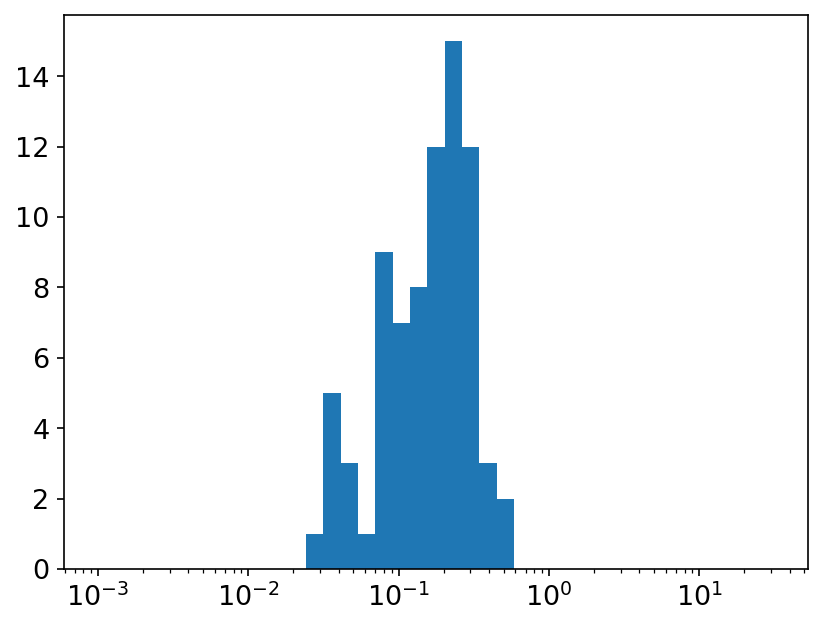

In [449]:
plt.hist(DrArr, bins=np.logspace(-3, 1.5, 40))
#plt.hist(DrErrArr, bins=np.logspace(-3, 2, 20))

plt.xscale('log')
plt.show()

In [450]:
np.median(DrArr)

0.17639321986311587

In [444]:
DrArr

[0.06745713860959679,
 0.4673159186627649,
 0.05533378210310862,
 0.02661192259654768,
 7.204455123237185e-09,
 0.03360990473422846,
 0.04638967468291392,
 0.013955604667164464,
 0.049533599487232044,
 0.04945262831166439,
 1.940855154123116e-08,
 0.03469336569330915,
 0.1710985573549407,
 0.07971757702986386,
 0.14207954852539703,
 0.07307233946152102,
 0.0429762705399428,
 0.0761904490275854,
 0.0941380335636598,
 0.07407819064520843,
 0.0815721275057823,
 0.11027571940098393,
 0.036343891736824424,
 0.00023810919411925682,
 0.14350267083995652,
 0.017095601959386347,
 0.11226251877487636,
 0.04751341016677744,
 0.11439719467744495,
 0.07458195079092858,
 0.09664594438464433,
 0.06970056555618392,
 0.09498265204648894,
 0.07314895265981292,
 0.07135094817237884,
 0.05942234340264227,
 0.04542576208640856,
 0.09552339352651301,
 0.08583842380889116,
 1.0650285157205924e-08,
 0.14582636043959474,
 0.09493283754234652,
 0.1327589087832397,
 0.055760589970048485,
 0.06185190251792868,
 0